In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import warnings
warnings.filterwarnings('ignore')

# Link to the dataset

https://www.kaggle.com/datasets/austinreese/usa-housing-listings

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('housing.csv')

In [25]:
df.shape

(384977, 22)

In [14]:
df.head(2)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7049044568,https://reno.craigslist.org/apa/d/reno-beautif...,reno / tahoe,https://reno.craigslist.org,1148,apartment,1078,3,2.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/01616_daghmBUvTC...,Ridgeview by Vintage is where you will find al...,39.5483,-119.796,ca
1,7049047186,https://reno.craigslist.org/apa/d/reno-reduced...,reno / tahoe,https://reno.craigslist.org,1200,condo,1001,2,2.0,0,...,0,0,0,w/d hookups,carport,https://images.craigslist.org/00V0V_5va0MkgO9q...,Conveniently located in the middle town of Ren...,39.5026,-119.789,ca


# 1. Data Cleaning

In [13]:
df.isnull().sum()

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             79026
parking_options            140687
image_url                       0
description                     2
lat                          1918
long                         1918
state                           0
dtype: int64

### 1.1 fill null values

In [ ]:
df['laundry_options'].fillna('no laundry on site', inplace=True)
df['parking_options'].fillna('no parking', inplace=True)
df['description'].fillna('no description', inplace=True)

In [22]:
df.isnull().sum()

id                            0
url                           0
region                        0
region_url                    0
price                         0
type                          0
sqfeet                        0
beds                          0
baths                         0
cats_allowed                  0
dogs_allowed                  0
smoking_allowed               0
wheelchair_access             0
electric_vehicle_charge       0
comes_furnished               0
laundry_options               0
parking_options               0
image_url                     0
description                   0
lat                        1918
long                       1918
state                         0
dtype: int64

### 1.2 filter out records outside of the USA

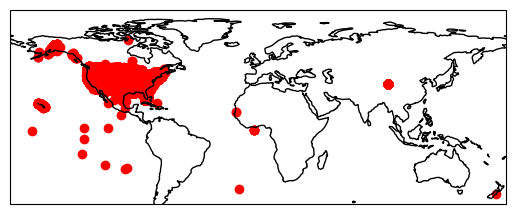

In [35]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

lats = df['lat'].values
lons = df['long'].values
ax.scatter(lons, lats, color='red', transform=ccrs.PlateCarree())

plt.show()


In [40]:
lat_min_main, lat_max_main = 24.396308, 49.384358
lon_min_main, lon_max_main = -125.0, -66.93457

lat_min_hawaii, lat_max_hawaii = 18.5, 22.5
lon_min_hawaii, lon_max_hawaii = -160, -154

df = df[
    ((df['lat'] >= lat_min_main) & 
     (df['lat'] <= lat_max_main) & 
     (df['long'] >= lon_min_main) & 
     (df['long'] <= lon_max_main)) |
    ((df['lat'] >= lat_min_hawaii) & 
     (df['lat'] <= lat_max_hawaii) & 
     (df['long'] >= lon_min_hawaii) & 
     (df['long'] <= lon_max_hawaii))
]


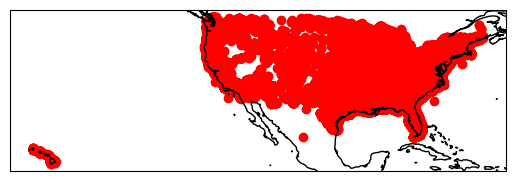

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()

lats = df['lat'].values
lons = df['long'].values
ax.scatter(lons, lats, color='red', transform=ccrs.PlateCarree())

plt.show()

### 1.3. Drop columns that are meaningless for analysis

In [51]:
df.drop(columns=['url', 'region_url', 'image_url'], inplace=True)